<a href="https://colab.research.google.com/github/VictorMadu/Stackover-question-tagging/blob/master/Data%20Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install scikit-multilearn

In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from zipfile import ZipFile
from sqlalchemy import create_engine
import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn import svm
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

### **1. Business Problem** 
Suggest the tags based on the content that was there in the question posted on StackOverflow




### **2. Real World/ Business Objectives and Constraints**
a. Predict as many tags as possible with high precision and recall

b. Incorrect tags could impact customer experience on StackOverflow

c. No strict latency constraints 

### **3.Machine Learning Problem**

3.1.1 Extracting the Train.csv file from the zip file

In [7]:
with ZipFile('/content/drive/My Drive/facebook-recruiting-iii-keyword-extraction.zip', 'r') as zf: 
  zf.printdir() 

  # extracting all the files 
  print('Extracting all the files now...') 
  zf.extractall() 
  print('Done!') 

File Name                                             Modified             Size
SampleSubmission.csv                           2019-12-11 23:27:44     82546830
Test.zip                                       2019-12-11 23:27:54    760327055
Train.zip                                      2019-12-11 23:29:10   2347110159
Extracting all the files now...
Done!


In [8]:
with ZipFile('/content/Train.zip') as zf:
  zf.printdir()

  # extracting .csv file from Train.zip
  print('Extracting the .csv file now...')
  zf.extractall()
  print('Done!')

File Name                                             Modified             Size
Train.csv                                      2013-07-22 14:50:22   7253917400
Extracting the .csv file now...
Done!


3.1.2 Loading the file

In [0]:
df = pd.read_csv('Train.csv')

3.1.2 Counting the number of rows and columns

In [4]:
print('The number of rows are:', df.shape[0])
print('The number of columns are:', df.shape[1])

The number of rows are: 6034195
The number of columns are: 4


3.1.3 Analysis on duplicates

In [5]:
df.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [6]:
print('The percentage of duplicate questions is:', df.duplicated(['Title', 'Body']).sum()*100/df.shape[0], '%')

The percentage of duplicate questions is: 31.088985357616053 %


In [7]:
print('The percentage of duplicate rows is:', df.duplicated(['Title', 'Body', 'Tags']).sum()*100/df.shape[0], '%')

The percentage of duplicate rows is: 30.29204392632323 %


3.1.4 Counting the number of times each question appeared in the data

In [8]:
print(df['Title'].value_counts()[:20])

Object reference not set to an instance of an object                                                     60
Help with SQL query                                                                                      23
Regular Expression                                                                                       22
What does this code do?                                                                                  19
The calling thread cannot access this object because a different thread owns it                          18
Input string was not in a correct format                                                                 18
Regular expression                                                                                       17
Validation of viewstate MAC failed                                                                       16
Help with sql query                                                                                      15
String was not recognized as

In [9]:
print(df['Body'].value_counts()[:20])

<p>Is it possible?</p>\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [10]:
print(df['Tags'].value_counts()[:20])

android              49783
php                  30664
jquery               28079
javascript           24995
javascript jquery    24955
java                 23751
c#                   22889
python               16470
php mysql            15798
mysql                15362
c++                  15328
html css             13296
iphone               12552
asp.net              11586
ruby-on-rails        10066
c# asp.net            9963
css                   8738
java android          8674
c                     8479
c# .net               6082
Name: Tags, dtype: int64


In [11]:
print(df.groupby(['Title', 'Body', 'Tags']).size().value_counts())

1    2656277
2    1272335
3     277575
4         90
5         25
6          5
dtype: int64


3.1.4 Remoing duplicates

In [12]:
df.drop_duplicates(['Title', 'Body', 'Tags'], inplace=True)
print('The number of rows of data without duplicates is:', df.shape[0])

The number of rows of data without duplicates is: 4206314


3.2 Analysis of Tags

3.2.1 Total number of unique tags

In [0]:
vectorizer = CountVectorizer(tokenizer= lambda x: x.split())
tag_dtm = vectorizer.fit_transform(df['Tags'].apply(lambda x: np.str_(x)))

In [14]:
print('The number of data points is:', tag_dtm.shape[0])
print('The number of unique tags is:', tag_dtm.shape[1])

The number of data points is: 4206314
The number of unique tags is: 42048


In [15]:
tags = vectorizer.get_feature_names()
print('Some of the tags are:', tags[:20])

Some of the tags are: ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store', '.each', '.emf', '.exe', '.exe.config', '.hgtags', '.htaccess', '.htpasswd', '.ico', '.lib', '.lrc']


In [0]:
freqs = tag_dtm.sum(axis=0).A1
results = dict(zip(tags, freqs))

In [17]:
tag_df = pd.DataFrame(results.items(), columns=['Tags', 'Counts'])
if not os.path.isfile('tag_counts_dict.csv'):
  tag_df.to_csv('tag_counts_dict.csv')

tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [0]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

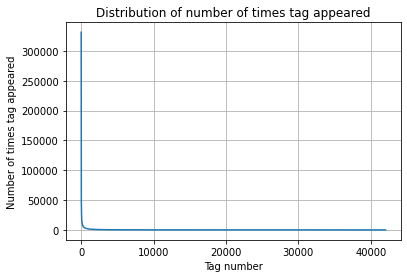

In [19]:
plt.plot(tag_counts)
plt.title('Distribution of number of times tag appeared')
plt.grid()
plt.xlabel('Tag number')
plt.ylabel('Number of times tag appeared')
plt.show()

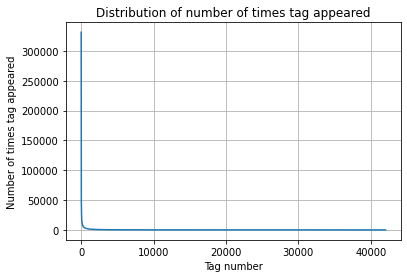

In [20]:
plt.plot(tag_counts[:100000])
plt.title('Distribution of number of times tag appeared')
plt.grid()
plt.xlabel('Tag number')
plt.ylabel('Number of times tag appeared')
plt.show()

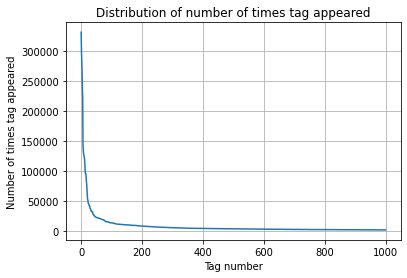

In [21]:
plt.plot(tag_counts[:1000])
plt.title('Distribution of number of times tag appeared')
plt.grid()
plt.xlabel('Tag number')
plt.ylabel('Number of times tag appeared')
plt.show()

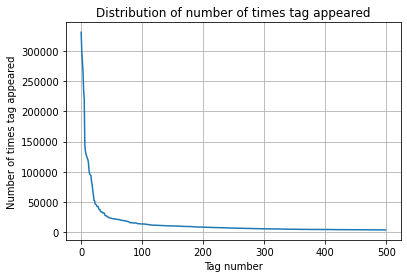

In [22]:
plt.plot(tag_counts[:500])
plt.title('Distribution of number of times tag appeared')
plt.grid()
plt.xlabel('Tag number')
plt.ylabel('Number of times tag appeared')
plt.show()

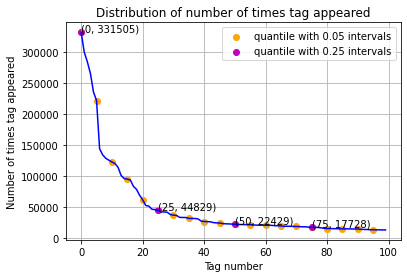

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [23]:
plt.plot(tag_counts[:100],c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label='quantile with 0.05 intervals')
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label='quantile with 0.25 intervals')

for x, y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
  plt.annotate(s="({}, {})".format(x, y), xy=(x, y), xytext=(x-0.05, y+500))
plt.title('Distribution of number of times tag appeared')
plt.grid()
plt.xlabel('Tag number')
plt.ylabel('Number of times tag appeared')
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [24]:
print('Number of times used more than 10000 times is:', len(tag_counts[tag_counts>10000]))

Number of times used more than 10000 times is: 153


In [25]:
print('Number of times used more than 100 times is:', len(tag_counts[tag_counts>100000]))

Number of times used more than 100 times is: 14


Micro-averaged F1-score is the appropiate metrics for this case since some tags occur more frequently than others

In [29]:
tag_quest_count = tag_dtm.sum(axis=1).tolist()
tag_quest_count = [int(j) for i in tag_quest_count for j in i]
print('We have total {} duplicates'.format(len(tag_quest_count)))
print(tag_quest_count[:10])

We have total 4206314 duplicates
[5, 1, 3, 3, 3, 3, 1, 3, 3, 5]


In [30]:
print('Maximum number of tags per question: %d'%max(tag_question_count))
print('Minimum number of tags per question: %d'%min(tag_question_count))
print('Avg. number of tags pre questions:%f'%(sum(tag_question_count)/len(tag_question_count)))

NameError: ignored

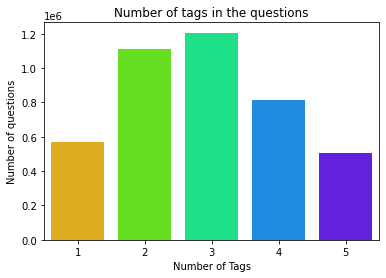

In [31]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title('Number of tags in the questions')
plt.xlabel('Number of Tags')
plt.ylabel('Number of questions')
plt.show()

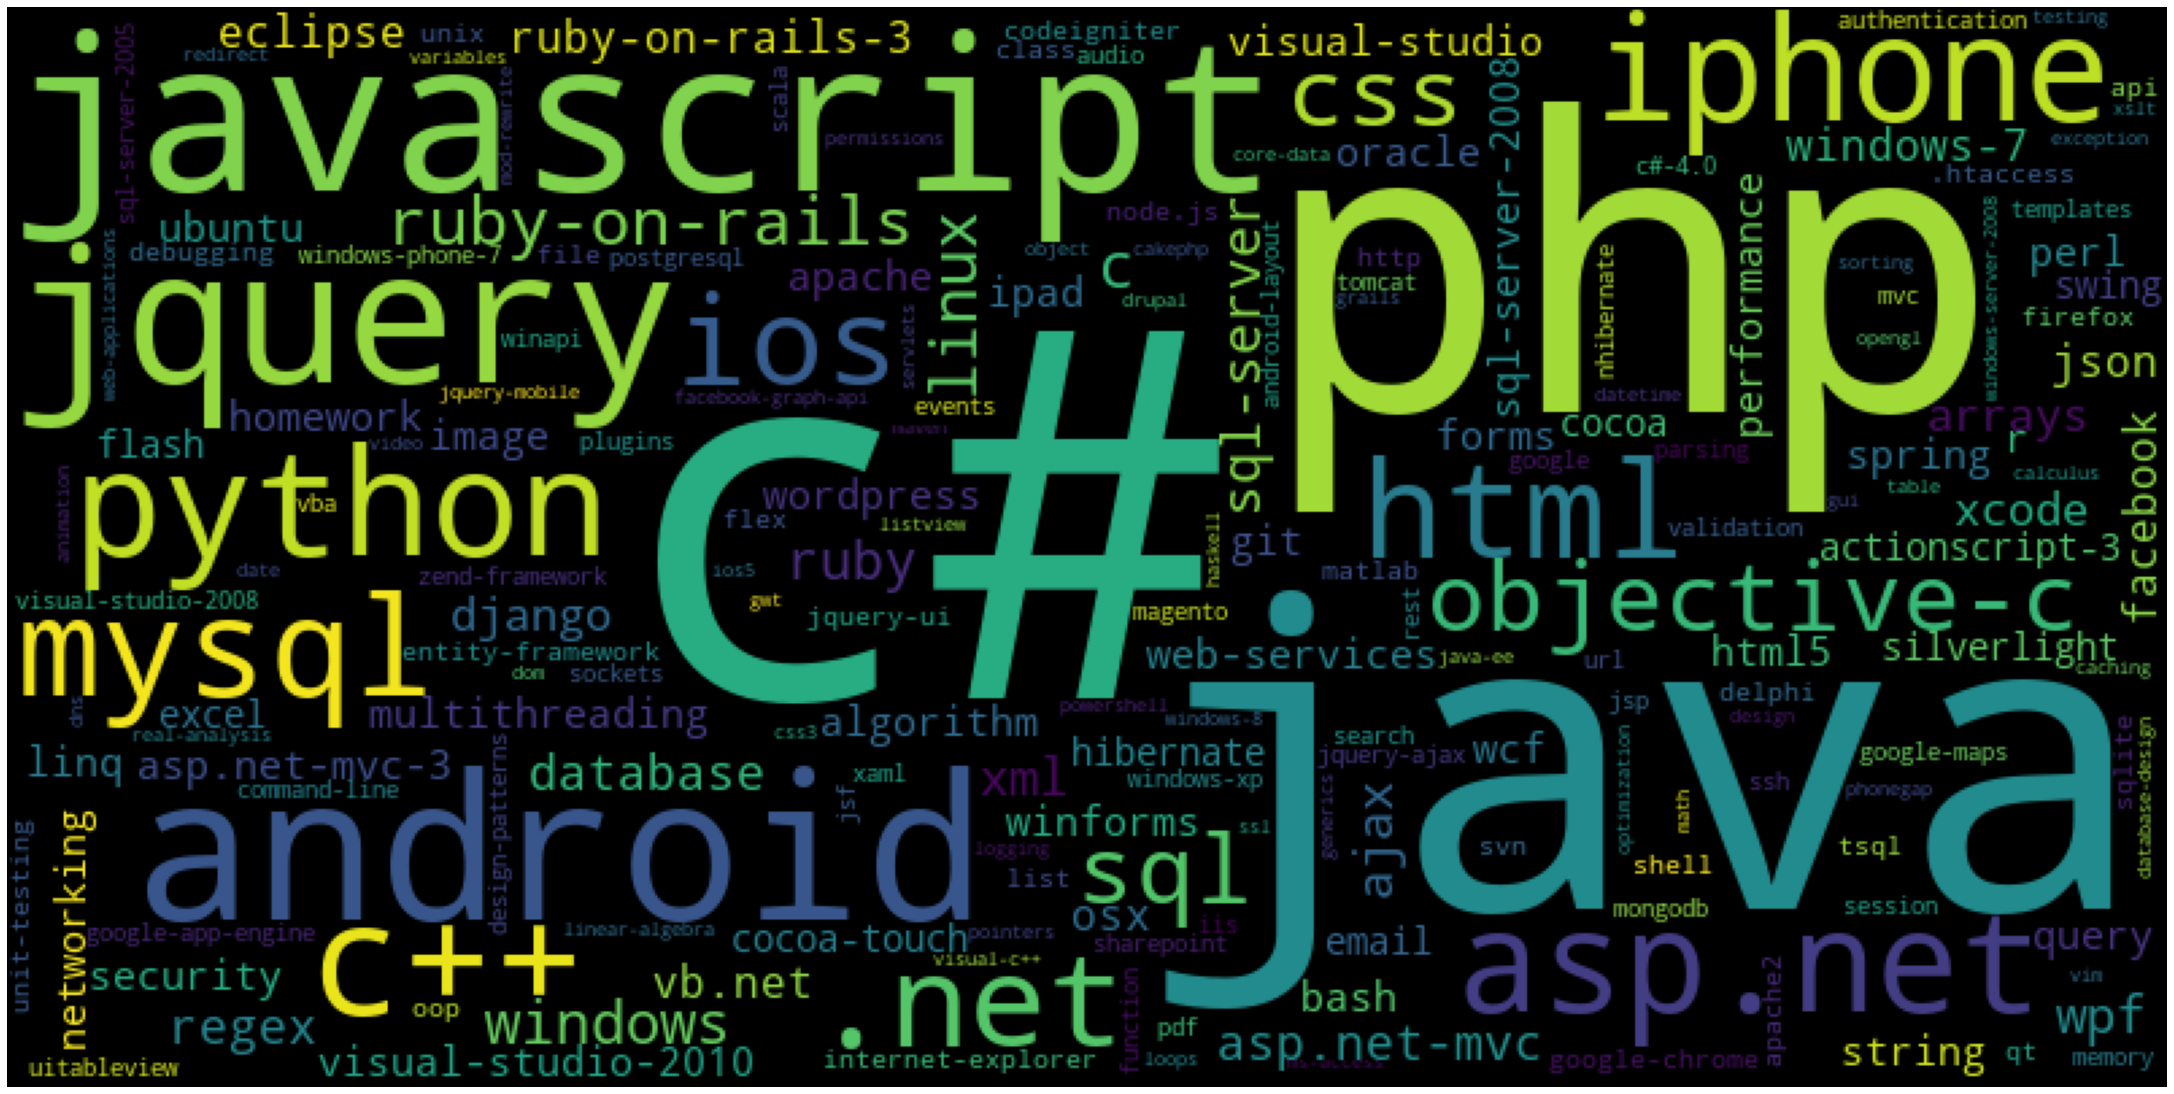

Time taken to run this cell: 0:00:02.130705


In [41]:
start = datetime.now()

tup = dict(results.items())
wordcloud = WordCloud(background_color='black',
                      width=800,
                      height=400).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30, 20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
print('Time taken to run this cell:', datetime.now()- start)

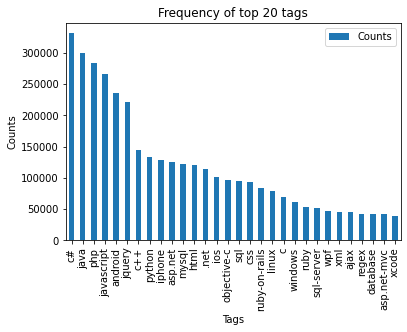

In [43]:
 i = np.arange(30)
 tag_df_sorted.head(30).plot(kind='bar')
 plt.title('Frequency of top 20 tags')
 plt.xticks(i, tag_df_sorted['Tags'])
 plt.xlabel('Tags')
 plt.ylabel('Counts')
 plt.show()

**Observations**

1. Majority of the most frequency words are programming languages

2. C# is the most frequency programming language

3. Andriod, IOS, Linux and Windows are among the most frequent operating system

In [0]:
df.to_csv('train.csv', index=False)